In [1]:
import scenicplus
import pycisTopic
import pandas as pd
from pycisTopic.plotting.qc_plot import plot_sample_stats, plot_barcode_stats
import matplotlib.pyplot as plt
import os
import pickle
from pycisTopic.qc import get_barcodes_passing_qc_for_sample
from pycisTopic.pseudobulk_peak_calling import export_pseudobulk
from pycisTopic.pseudobulk_peak_calling import peak_calling
from pycisTopic.iterative_peak_calling import get_consensus_peaks
from pycisTopic.iterative_peak_calling import get_consensus_peaks
from pycisTopic.lda_models import evaluate_models




out_dir = "outs"
os.makedirs(out_dir, exist_ok = True)
os.makedirs(os.path.join(out_dir, "consensus_peak_calling"), exist_ok = True)
os.makedirs(os.path.join(out_dir, "consensus_peak_calling/pseudobulk_bed_files"), exist_ok = True)
os.makedirs(os.path.join(out_dir, "consensus_peak_calling/pseudobulk_bw_files"), exist_ok = True)

/home/adrienne/mambaforge/envs/scenicplus_release/lib/python3.11/site-packages/pycisTopic/__init__.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution
/home/adrienne/mambaforge/envs/scenicplus_release/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-09-05 12:25:48,654	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


!mkdir -p data
!wget -O data/fragments.tsv.gz https://cf.10xgenomics.com/samples/cell-arc/1.0.0/human_brain_3k/human_brain_3k_atac_fragments.tsv.gz
!wget -O data/fragments.tsv.gz.tbi https://cf.10xgenomics.com/samples/cell-arc/1.0.0/human_brain_3k/human_brain_3k_atac_fragments.tsv.gz.tbi
!wget -O data/cell_data.tsv https://raw.githubusercontent.com/aertslab/pycisTopic/polars/data/cell_data_human_cerebellum.tsv

In [2]:
print(pycisTopic.__version__)
#print(scenicplus.__version__)

2.0a0


In [3]:
fragments_dict = {
    "10x_multiome_brain": "data/fragments.tsv.gz"
}

In [4]:
cell_data = pd.read_table("data/cell_data.tsv", index_col = 0)
cell_data.head()

,VSN_cell_type,VSN_leiden_res0.3,VSN_leiden_res0.6,VSN_leiden_res0.9,VSN_leiden_res1.2,VSN_sample_id,Seurat_leiden_res0.6,Seurat_leiden_res1.2,Seurat_cell_type
AAACAGCCATTATGCG-1-10x_multiome_brain,MOL_B,MOL_B (0),MOL_B_1 (0),MOL_B_1 (1),MOL_B_3 (6),10x_multiome_brain,NFOL (1),MOL (1),MOL
AAACCAACATAGACCC-1-10x_multiome_brain,MOL_B,MOL_B (0),MOL_B_1 (0),MOL_B_3 (5),MOL_B_4 (4),10x_multiome_brain,NFOL (1),NFOL (3),NFOL
AAACCGAAGATGCCTG-1-10x_multiome_brain,INH_VIP,INH_VIP (6),INH_VIP (8),INH_VIP (8),INH_VIP (10),10x_multiome_brain,INH_VIP (7),INH_VIP (6),INH_VIP
AAACCGAAGTTAGCTA-1-10x_multiome_brain,MOL_A,MOL_A (1),MOL_A_2 (1),MOL_A_1 (0),MOL_A_2 (0),10x_multiome_brain,NFOL (1),NFOL (3),NFOL
AAACCGCGTTAGCCAA-1-10x_multiome_brain,MGL,MGL (7),MGL (10),MGL (10),MGL (12),10x_multiome_brain,MGL (8),MGL (9),MGL


In [5]:
chromsizes = pd.read_table(
    "http://hgdownload.cse.ucsc.edu/goldenPath/hg38/bigZips/hg38.chrom.sizes",
    header = None,
    names = ["Chromosome", "End"]
)
chromsizes.insert(1, "Start", 0)
chromsizes.head()

,Chromosome,Start,End
0,chr1,0,248956422
1,chr2,0,242193529
2,chr3,0,198295559
3,chr4,0,190214555
4,chr5,0,181538259


In [6]:
bw_paths, bed_paths = export_pseudobulk(
    input_data = cell_data,
    variable = "VSN_cell_type",
    sample_id_col = "VSN_sample_id",
    chromsizes = chromsizes,
    bed_path = os.path.join(out_dir, "consensus_peak_calling/pseudobulk_bed_files"),
    bigwig_path = os.path.join(out_dir, "consensus_peak_calling/pseudobulk_bw_files"),
    path_to_fragments = fragments_dict,
    n_cpu = 10,
    normalize_bigwig = True,
    temp_dir = "/tmp",
    split_pattern = "-"
)

2025-09-05 12:25:49,293 cisTopic     INFO     Splitting fragments by cell type.
2025-09-05 12:27:27,885 cisTopic     INFO     generating bigwig files


/home/adrienne/mambaforge/envs/scenicplus_release/lib/python3.11/site-packages/pycisTopic/__init__.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution
/home/adrienne/mambaforge/envs/scenicplus_release/lib/python3.11/site-packages/pycisTopic/__init__.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution
/home/adrienne/mambaforge/envs/scenicplus_release/lib/python3.11/site-packages/pycisTopic/__init__.py:3: UserWarning: pkg_resources is deprecated as an API. See https://set

In [7]:
with open(os.path.join(out_dir, "consensus_peak_calling/bw_paths.tsv"), "wt") as f:
    for v in bw_paths:
        _ = f.write(f"{v}\t{bw_paths[v]}\n")

with open(os.path.join(out_dir, "consensus_peak_calling/bed_paths.tsv"), "wt") as f:
    for v in bed_paths:
        _ = f.write(f"{v}\t{bed_paths[v]}\n")

In [8]:
bw_paths = {}
with open(os.path.join(out_dir, "consensus_peak_calling/bw_paths.tsv")) as f:
    for line in f:
        v, p = line.strip().split("\t")
        bw_paths.update({v: p})

    
bed_paths = {}
with open(os.path.join(out_dir, "consensus_peak_calling/bed_paths.tsv")) as f:
    for line in f:
        v, p = line.strip().split("\t")
        bed_paths.update({v: p})

In [9]:
macs_path = "macs3"

os.makedirs(os.path.join(out_dir, "consensus_peak_calling/MACS"), exist_ok = True)

narrow_peak_dict = peak_calling(
    macs_path = macs_path,
    bed_paths = bed_paths,
    outdir = os.path.join(os.path.join(out_dir, "consensus_peak_calling/MACS")),
    genome_size = 'hs',
    n_cpu = 10,
    input_format = 'BEDPE',
    shift = 73,
    ext_size = 146,
    keep_dup = 'all',
    q_value = 0.05#,
    #_temp_dir = '/scratch/leuven/330/vsc33053/ray_spill'
)

2025-09-05 12:28:22,076	INFO worker.py:1951 -- Started a local Ray instance.
(pid=30416) /home/adrienne/mambaforge/envs/scenicplus_release/lib/python3.11/site-packages/pycisTopic/__init__.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
(pid=30416)   from pkg_resources import DistributionNotFound, get_distribution


(macs_call_peak_ray pid=30416) 2025-09-05 12:28:23,875 cisTopic     INFO     Calling peaks for AST_CER with macs3 callpeak --treatment outs/consensus_peak_calling/pseudobulk_bed_files/AST_CER.fragments.tsv.gz --name AST_CER  --outdir outs/consensus_peak_calling/MACS --format BEDPE --gsize hs --qvalue 0.05 --nomodel --shift 73 --extsize 146 --keep-dup all --call-summits --nolambda
(macs_call_peak_ray pid=30407) 2025-09-05 12:28:23,877 cisTopic     INFO     Calling peaks for MOL_A with macs3 callpeak --treatment outs/consensus_peak_calling/pseudobulk_bed_files/MOL_A.fragments.tsv.gz --name MOL_A  --outdir outs/consensus_peak_calling/MACS --format BEDPE --gsize hs --qvalue 0.05 --nomodel --shift 73 --extsize 146 --keep-dup all --call-summits --nolambda
(macs_call_peak_ray pid=30411) 2025-09-05 12:28:23,984 cisTopic     INFO     Calling peaks for MGL with macs3 callpeak --treatment outs/consensus_peak_calling/pseudobulk_bed_files/MGL.fragments.tsv.gz --name MGL  --outdir outs/consensus_pea

(pid=30413) /home/adrienne/mambaforge/envs/scenicplus_release/lib/python3.11/site-packages/pycisTopic/__init__.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81. [repeated 9x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#log-deduplication for more options.)
(pid=30413)   from pkg_resources import DistributionNotFound, get_distribution [repeated 9x across cluster]


In [10]:
# Other param
peak_half_width=250
path_to_blacklist="pycisTopic/blacklist/hg38-blacklist.v2.bed"
# Get consensus peaks
consensus_peaks = get_consensus_peaks(
    narrow_peaks_dict = narrow_peak_dict,
    peak_half_width = peak_half_width,
    chromsizes = chromsizes,
    path_to_blacklist = path_to_blacklist)

2025-09-05 12:30:15,972 cisTopic     INFO     Extending and merging peaks per class


2025-09-05 12:31:10,788 cisTopic     INFO     Normalizing peak scores
2025-09-05 12:31:11,336 cisTopic     INFO     Merging peaks
2025-09-05 12:32:16,662 cisTopic     INFO     Done!


In [11]:
consensus_peaks.to_bed(
    path = os.path.join(out_dir, "consensus_peak_calling/consensus_regions.bed"),
    keep =True,
    compression = 'infer',
    chain = False)

In [12]:
!pycistopic tss gene_annotation_list | grep Human

/home/adrienne/mambaforge/envs/scenicplus_release/lib/python3.11/site-packages/pycisTopic/__init__.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution
hsapiens_gene_ensembl	Human genes (GRCh38.p14)


In [13]:
!mkdir -p outs/qc
!pycistopic tss get_tss \
    --output outs/qc/tss.bed \
    --name "hsapiens_gene_ensembl" \
    --to-chrom-source ucsc \
    --ucsc hg38

/home/adrienne/mambaforge/envs/scenicplus_release/lib/python3.11/site-packages/pycisTopic/__init__.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution
- Get TSS annotation from Ensembl BioMart with the following settings:
  - biomart_name: "hsapiens_gene_ensembl"
  - biomart_host: "http://www.ensembl.org"
  - transcript_type: ['protein_coding']
  - use_cache: True
/home/adrienne/mambaforge/envs/scenicplus_release/lib/python3.11/site-packages/pybiomart/dataset.py:269: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  result = pd.read_csv(StringIO(response.text), sep='\t')
Traceback (most recent call last):
  File "/home/adrienne/mambaforge/envs/scenicplus_release/bin/pycistopic

In [14]:
!head outs/qc/tss.bed | column -t

#     Chromosome  Start  End      Gene  Score  Strand          Transcript_type
chrM  3306        3307   MT-ND1   .     +      protein_coding
chrM  4469        4470   MT-ND2   .     +      protein_coding
chrM  5903        5904   MT-CO1   .     +      protein_coding
chrM  7585        7586   MT-CO2   .     +      protein_coding
chrM  8365        8366   MT-ATP8  .     +      protein_coding
chrM  8526        8527   MT-ATP6  .     +      protein_coding
chrM  9206        9207   MT-CO3   .     +      protein_coding
chrM  10058       10059  MT-ND3   .     +      protein_coding
chrM  10469       10470  MT-ND4L  .     +      protein_coding


In [15]:
fragments_dict

{'10x_multiome_brain': 'data/fragments.tsv.gz'}

In [16]:
regions_bed_filename = os.path.join(out_dir, "consensus_peak_calling/consensus_regions.bed")
tss_bed_filename = os.path.join(out_dir, "qc", "tss.bed")

pycistopic_qc_commands_filename = "pycistopic_qc_commands.txt"

# Create text file with all pycistopic qc command lines.
with open(pycistopic_qc_commands_filename, "w") as fh:
    for sample, fragment_filename in fragments_dict.items():
        print(
            "pycistopic qc",
            f"--fragments {fragment_filename}",
            f"--regions {regions_bed_filename}",
            f"--tss {tss_bed_filename}",
            f"--output {os.path.join(out_dir, 'qc')}/{sample}",
            sep=" ",
            file=fh,
        )

In [17]:
!bash pycistopic_qc_commands.txt 

/home/adrienne/mambaforge/envs/scenicplus_release/lib/python3.11/site-packages/pycisTopic/__init__.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution
/home/adrienne/mambaforge/envs/scenicplus_release/lib/python3.11/site-packages/pycisTopic/genomic_ranges.py:354: PerformanceWarning: Determining the column names of a LazyFrame requires resolving its schema, which is a potentially expensive operation. Use `LazyFrame.collect_schema().names()` to get the column names without this warning.
  for column_name in df.columns
/home/adrienne/mambaforge/envs/scenicplus_release/lib/python3.11/site-packages/pycisTopic/genomic_ranges.py:369: PerformanceWarning: Determining the column names of a LazyFrame requires resolving its schema, which i

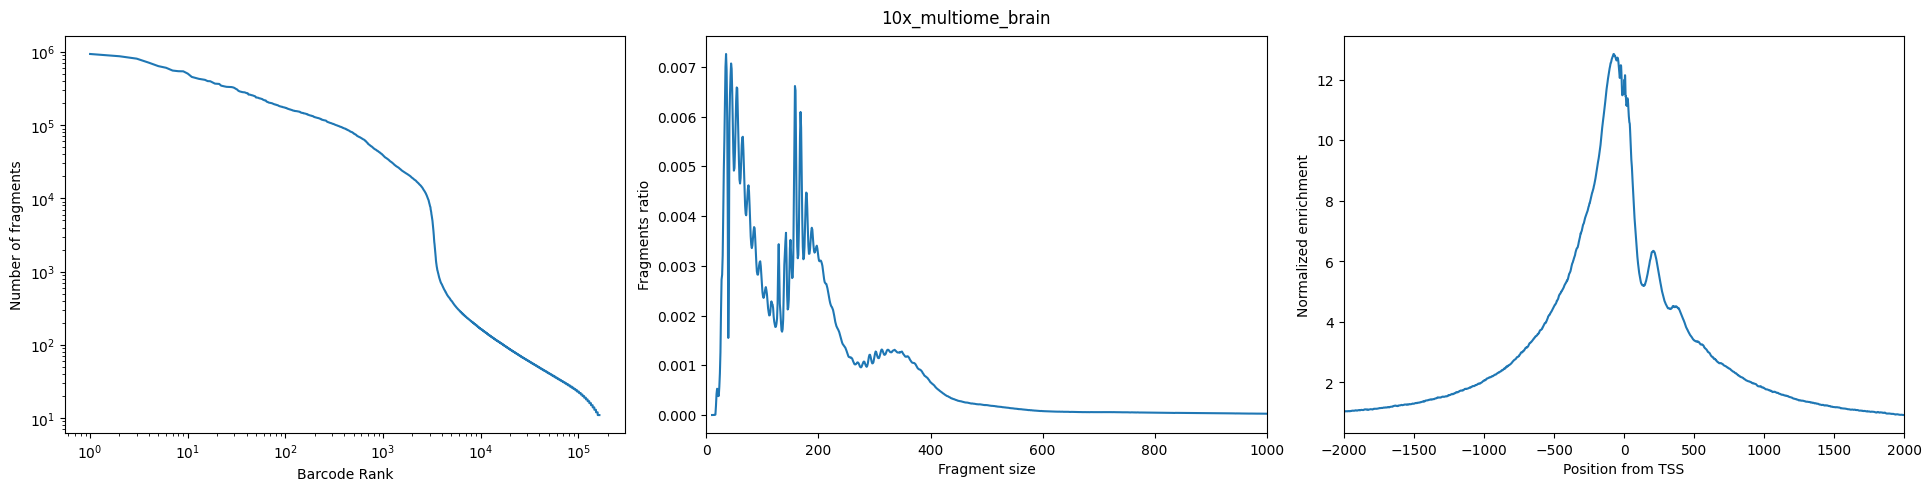

In [18]:
for sample_id in fragments_dict:
    fig = plot_sample_stats(
        sample_id = sample_id,
        pycistopic_qc_output_dir = "outs/qc"
    )

In [19]:
sample_id_to_barcodes_passing_filters = {}
sample_id_to_thresholds = {}
for sample_id in fragments_dict:
    (
        sample_id_to_barcodes_passing_filters[sample_id],
        sample_id_to_thresholds[sample_id]
    ) = get_barcodes_passing_qc_for_sample(
            sample_id = sample_id,
            pycistopic_qc_output_dir = "outs/qc",
            unique_fragments_threshold = None, # use automatic thresholding
            tss_enrichment_threshold = None, # use automatic thresholding
            frip_threshold = 0,
            use_automatic_thresholds = True,
    )

10x_multiome_brain:
	Using automatic threshold for unique fragments: 1500.0602867310176
	Using automatic threshold for TSS enrichment: 7.547809932602457


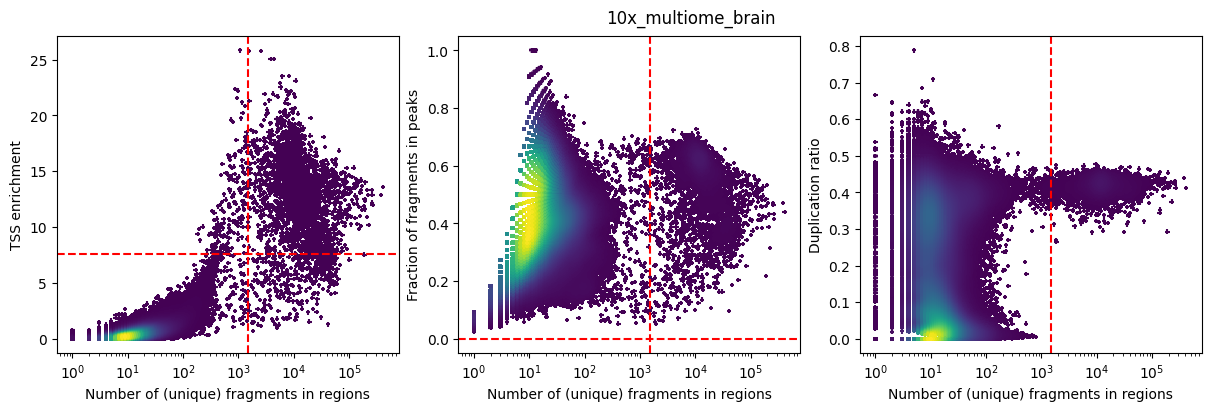

In [20]:
for sample_id in fragments_dict:
    fig = plot_barcode_stats(
        sample_id = sample_id,
        pycistopic_qc_output_dir = "outs/qc",
        bc_passing_filters = sample_id_to_barcodes_passing_filters[sample_id],
        detailed_title = False,
        **sample_id_to_thresholds[sample_id]
    )

In [21]:
path_to_regions = os.path.join(out_dir, "consensus_peak_calling/consensus_regions.bed")
path_to_blacklist = "pycisTopic/blacklist/hg38-blacklist.v2.bed"
pycistopic_qc_output_dir = "outs/qc"

from pycisTopic.cistopic_class import create_cistopic_object_from_fragments
import polars as pl

cistopic_obj_list = []
for sample_id in fragments_dict:
    sample_metrics = pl.read_parquet(
        os.path.join(pycistopic_qc_output_dir, f'{sample_id}.fragments_stats_per_cb.parquet')
    ).to_pandas().set_index("CB").loc[ sample_id_to_barcodes_passing_filters[sample_id] ]
    cistopic_obj = create_cistopic_object_from_fragments(
        path_to_fragments = fragments_dict[sample_id],
        path_to_regions = path_to_regions,
        path_to_blacklist = path_to_blacklist,
        metrics = sample_metrics,
        valid_bc = sample_id_to_barcodes_passing_filters[sample_id],
        n_cpu = 1,
        project = sample_id,
        split_pattern = '-'
    )
    cistopic_obj_list.append(cistopic_obj)

2025-09-05 12:35:32,148 cisTopic     INFO     Reading data for 10x_multiome_brain


2025-09-05 12:37:16,544 cisTopic     INFO     metrics provided!
2025-09-05 12:37:25,056 cisTopic     INFO     Counting fragments in regions
2025-09-05 12:38:34,117 cisTopic     INFO     Creating fragment matrix
2025-09-05 12:39:14,593 cisTopic     INFO     Converting fragment matrix to sparse matrix
2025-09-05 12:39:20,794 cisTopic     INFO     Removing blacklisted regions
2025-09-05 12:39:22,024 cisTopic     INFO     Creating CistopicObject
2025-09-05 12:39:23,746 cisTopic     INFO     Done!


In [22]:
cistopic_obj = cistopic_obj_list[0]
print(cistopic_obj)

CistopicObject from project 10x_multiome_brain with n_cells × n_regions = 2850 × 436208


In [23]:
pickle.dump(
    cistopic_obj,
    open(os.path.join(out_dir, "cistopic_obj.pkl"), "wb")
)

In [24]:
import pandas as pd
cell_data = pd.read_table("data/cell_data.tsv", index_col = 0)
cell_data.head()
cistopic_obj.add_cell_data(cell_data, split_pattern='-')
pickle.dump(
    cistopic_obj,
    open(os.path.join(out_dir, "cistopic_obj.pkl"), "wb")
)

In [25]:
cistopic_obj.cell_data

,cisTopic_nr_frag,cisTopic_log_nr_frag,cisTopic_nr_acc,cisTopic_log_nr_acc,sample_id,barcode_rank,total_fragments_count,log10_total_fragments_count,unique_fragments_count,log10_unique_fragments_count,...,barcode,VSN_cell_type,VSN_leiden_res0.3,VSN_leiden_res0.6,VSN_leiden_res0.9,VSN_leiden_res1.2,VSN_sample_id,Seurat_leiden_res0.6,Seurat_leiden_res1.2,Seurat_cell_type
CACCTCAGTTGTAAAC-1-10x_multiome_brain,18299,4.262427,15554,4.191842,10x_multiome_brain,1263,47941,4.680716,30052,4.477888,...,CACCTCAGTTGTAAAC-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TGACTCCTCATCCACC-1-10x_multiome_brain,100039,5.000169,62273,4.7943,10x_multiome_brain,93,311527,5.493497,177932,5.250257,...,TGACTCCTCATCCACC-1,AST_CER,AST_CER (2),AST_CER (2),AST_CER (2),AST_CER_1 (7),10x_multiome_brain,BG (2),BG (2),BG
TTTCTCACATAAACCT-1-10x_multiome_brain,32163,4.507357,26977,4.430994,10x_multiome_brain,594,110849,5.044736,67109,4.826787,...,TTTCTCACATAAACCT-1,GC,GC (4),GC (5),GC (6),GC (8),10x_multiome_brain,GC (4),GC (5),GC
GTCCTCCCACACAATT-1-10x_multiome_brain,88413,4.946516,58280,4.76552,10x_multiome_brain,97,325923,5.513116,174752,5.242425,...,GTCCTCCCACACAATT-1,AST_CER,AST_CER (2),AST_CER (2),AST_CER (2),AST_CER_1 (7),10x_multiome_brain,BG (2),BG (2),BG
CTCCGTCCAGTTTGTG-1-10x_multiome_brain,131046,5.117424,78484,4.894781,10x_multiome_brain,54,405882,5.608401,232359,5.366161,...,CTCCGTCCAGTTTGTG-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GCAGGTTGTCCAAATG-1-10x_multiome_brain,2771,3.442637,2614,3.417306,10x_multiome_brain,3258,7170,3.855580,4043,3.606811,...,GCAGGTTGTCCAAATG-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAGCTCCCAGCACCAT-1-10x_multiome_brain,2180,3.338456,2040,3.30963,10x_multiome_brain,3148,9905,3.995898,5832,3.765892,...,AAGCTCCCAGCACCAT-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CAGAATCTCCTCATGC-1-10x_multiome_brain,1743,3.241297,1680,3.225309,10x_multiome_brain,3340,4638,3.666424,2655,3.424228,...,CAGAATCTCCTCATGC-1,MOL_B,MOL_B (0),MOL_B_1 (0),MOL_B_1 (1),MOL_B_1 (1),10x_multiome_brain,MOL (0),MOL (1),MOL
TAGCCGGGTAACAGGG-1-10x_multiome_brain,2673,3.426999,2414,3.382737,10x_multiome_brain,3134,10310,4.013301,6033,3.780605,...,TAGCCGGGTAACAGGG-1,ENDO,MOL_A (1),MOL_A_2 (1),MOL_A_1 (0),ENDO (18),10x_multiome_brain,AST+ENDO (6),ENDO (15),ENDO


!wget https://github.com/mimno/Mallet/releases/download/v202108/Mallet-202108-bin.tar.gz
!tar -xf Mallet-202108-bin.tar.gz

In [26]:
!mkdir -p mallet/tutorial/

In [ ]:
os.environ['MALLET_MEMORY'] = '150G'
from pycisTopic.lda_models import run_cgs_models_mallet
# Configure path Mallet
mallet_path="Mallet-202108/bin/mallet"
# Run models
models=run_cgs_models_mallet(
    cistopic_obj,
    n_topics=[2, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50],
    n_cpu=12,
    n_iter=500,
    random_state=555,
    alpha=50,
    alpha_by_topic=True,
    eta=0.1,
    eta_by_topic=False,
    tmp_path="mallet/tutorial",
    save_path="mallet/tutorial",
    mallet_path=mallet_path,
)

2025-09-05 12:39:52,780 cisTopic     INFO     Formatting input to corpus
2025-09-05 12:39:53,405 cisTopic     INFO     Running model with 2 topics
2025-09-05 12:39:53,406 LDAMalletWrapper INFO     Serializing temporary corpus to mallet/tutorial/corpus.txt
2025-09-05 12:40:09,319 LDAMalletWrapper INFO     Converting temporary corpus to MALLET format with: Mallet-202108/bin/mallet import-file --preserve-case --keep-sequence --token-regex \S+ --input mallet/tutorial/corpus.txt --output mallet/tutorial/corpus.mallet
2025-09-05 12:40:34,240 LDAMalletWrapper INFO     Training MALLET LDA with: Mallet-202108/bin/mallet train-topics --input mallet/tutorial/corpus.mallet --num-topics 2 --alpha 50 --beta 0.1 --optimize-interval 0 --num-threads 12 --output-state mallet/tutorial/6f5870_state.mallet.gz --output-doc-topics mallet/tutorial/6f5870_doctopics.txt --output-topic-keys mallet/tutorial/6f5870_topickeys.txt --num-iterations 500 --inferencer-filename mallet/tutorial/6f5870_inferencer.mallet --

In [ ]:
pickle.dump(
    models,
    open(os.path.join(out_dir, "models.pkl"), "wb")
)

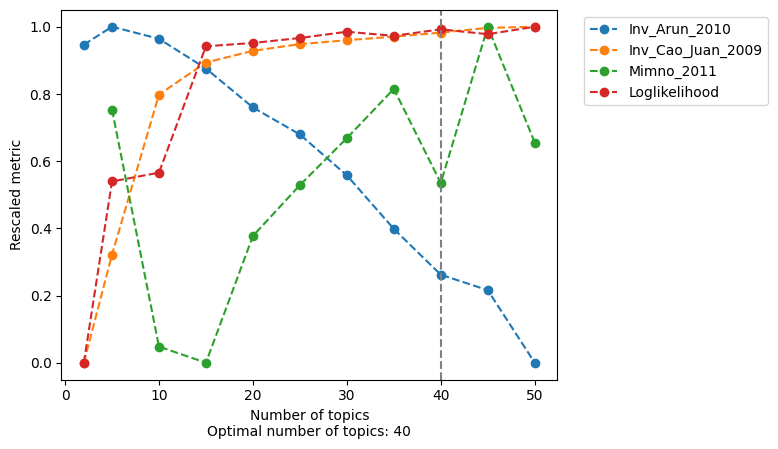

In [ ]:
model = evaluate_models(
    models,
    select_model = 40,
    return_model = True
)

In [ ]:
cistopic_obj.add_LDA_model(model)
pickle.dump(
    cistopic_obj,
    open(os.path.join(out_dir, "cistopic_obj.pkl"), "wb")
)

In [ ]:
from pycisTopic.clust_vis import (
    find_clusters,
    run_umap,
    run_tsne,
    plot_metadata,
    plot_topic,
    cell_topic_heatmap
)